In [337]:
import array as arr
import csv
import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [338]:
def step(t, dt):
    t = t + dt
    return t

In [339]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

    #     print("x-loc rectangle,", x, "y-loc rectangle,", y)

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [340]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [341]:
class camera(object):
    def __init__(self):      
        
        #################### CLASS VARIABLES ####################
        self.width = 2         # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index

        ######################## MODULES ########################
        self.indexVisFruit = queue.SimpleQueue()
        
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        view_min = q_curr - self.width / 2
        view_max = q_curr + self.width / 2

        # fix end constraints of beginning and end 
        if view_min < 0:
            view_min = 0

        if view_max > end_row:
            view_max = end_row

        i = self.i_lastFruit # might need to change this if fruits move around

        # look through sorted (around y-axis) array to find all "visible fruit"
        while(True):
            if sortedFruit[1,i] > view_min and sortedFruit[1,i] < view_max:
                self.indexVisFruit.put(i)
                
            elif sortedFruit[1,i] > view_max:
                break
            i = i + 1
            
        self.i_lastFruit = i


In [342]:
def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
    i_goal = indexVisFruit.get()
#     print(i_goal)

In [343]:
class arm(object):
    def __init__(self, q, n):
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.q_zero        = np.array([q[0],q[1],q[2]])  # arm's zero location (can go back to it)
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 7.      # how far can it go into trees, in m
        self.width_f       = 5. #7.5     # size of enclosing frame, width in m
        self.height_f      = 4.      # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([self.q_a[0],self.q_a[1],self.q_a[2]/2])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.])
        self.y_edges_f     = np.array([0.,0.])
        self.z_edges_f     = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = 1.
        self.a_max         = 10. 
        self.d_max         = 10.
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
#     def armStep(self, v_v, q_curr, dt, t):
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # q_curr is the arm's current location within the world frame
        q_curr      = np.array([0.,0.,0.])
        # v_v is the vehicle's velocity
        q_curr[0]   = self.q_a[0]
        q_curr[1]   = self.q_a[1]
        q_curr[2]   = self.q_a[2]
        
#         print("has goal been reached, x, y, z", self.goal_r)

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        can_reach   = 1               # start with the possibility that a fruit can be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        else:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
                self.calcXVel(goal_time_x, v_v)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt             
        
        # update the zero location to follow the vehicle
        self.q_zero[0] += v_v[0]*dt
        self.q_zero[1] += v_v[1]*dt
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)
        
#         print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#         print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))
#         print("")
        
        # if goal has been reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_zero[0]+epsilon or self.q_a[0] < self.q_zero[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = 0.      # start time for the new timer for x
                # check if the goal was reached within +/- some error
                if ((self.q_a[0] > (self.goal[0]-epsilon) or self.q_a[0] < (self.goal[0]+epsilon)) and
                    (self.q_a[1] > (self.goal[1]-epsilon) or self.q_a[1] < (self.goal[1]+epsilon)) and
                    (self.q_a[2] > (self.goal[2]-epsilon) or self.q_a[2] < (self.goal[2]+epsilon))):
                    # find a better way to do this 
                    self.reached_goals += 1
#                     print("GOAL REACHED")
                
            elif self.retractFlag == 0:
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_zero[0], self.x.v0, self.v_max, self.a_max, self.d_max)
#         print("RETRACTING")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)       
#         print(" ")
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
        print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
        print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
        print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
        print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future"
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is passed the edge of the back frame

            if self.goal[2] < self.z_edges_f[0] and self.goal[2] > self.z_edges_f[1]:
                # check again if the goal is within the top and bottom of the frame
                return 1

            else:
                return 0
        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [344]:
# open CSV file and populate fruits on grid
x_fr = []
y_fr = []
z_fr = []

# with open('Applestotheleft.csv', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
#     for row in spamreader:
#         x_fr.append(float(row[0]))
#         y_fr.append(float(row[1]))
#         z_fr.append(float(row[2]))
        
with open('Applestotheright.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        x_fr.append(float(row[0]))
        y_fr.append(float(row[1]))
        z_fr.append(float(row[2]))

x_fruit = np.array(x_fr)
y_fruit = np.array(y_fr)
z_fruit = np.array(z_fr)

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x_fr, y_fr, z_fruit])

rowIndex = 1 # sort based on y-axis
sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [345]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 16.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

dr = drawRobot()

In [346]:
# init vehicle
width_v = 1     # vehicle width
length_v = 5    # vehicle length
num_arms = 1    # set number of arms on robot

q_v = np.array([5.5,7.]) # starting location
v_v = np.array([0.,0.1]) # in m, constant velocity
# v_v = np.array([0.,0.]) # in m, constant velocity to easily change between the two

qv0 = []
qv1 = []

In [347]:
# init camera
picture = camera()

In [348]:
# init scheduler
goal = np.zeros(3) # does ithis go here?

In [349]:
# init arms
q_a     = np.array([q_v[0],q_v[1],4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.])

a = []  # list of arm objects 

# initialize the arms in a list
for count in range(num_arms):
    # calculate where each new arm should go
    q_a_new[0] = q_a[0]             # doesn't change right now
    q_a_new[1] = q_a[1] + 3.*count  # place it next to the previous arm
    q_a_new[2] = q_a[2]             # doesn't change right now
    # initialize the new arm
    x = arm(q_a_new, count)
    # add the arm to the a-list
    a.append(x)

for count in range(num_arms):
    print("arm number, arm location:", a[count].n, a[count].q_a)

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []

arm number, arm location: 0 [5.5 7.  4. ]


In [350]:
# start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a FIFO queue of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    
    # schedule
    # check if there are any arms that are free 
    for arm_free in range(num_arms):
#         if a1.free == 1:
        if a[arm_free].free == 1:
            # make sure there are available goals left in the queue
            if not picture.indexVisFruit.empty():
                i_f = picture.indexVisFruit.get()  # get a new goal
        #         print(picture.indexVisFruit.qsize()) # check the size of the queue
                # check if arm can get it in the y-dir
                if a[arm_free].q_a[1] > sortedFruit[2,i_f]:
                    # give the goal 
                    a[arm_free].setGoal(sortedFruit[:,i_f], t_new)
                # need to add a check to see if the machine can still get it?
            else:
#                 a1.goal = ([0,0,0]) # clear the goal section I guess
                a[arm_free].goal = ([a[arm_free].q_zero[0],a[arm_free].q_zero[1],a[arm_free].q_zero[2]]) # clear the goal section I guess
                a[arm_free].setGoal(a[arm_free].goal, t_new)

    
    # have each arm take a step
    for arm2step in range(num_arms):
#         q_a = a1.armStep(v_v, q_a, dt, t_new)
        q_a = a[arm2step].armStep(v_v, dt, t_new)
#         print("arm location:", q_a)


#    # when the vehicle is stopped, gives an end to the while loop
#     if a1.error[1] == math.inf or a1.error[1] == -math.inf:
#         print("end of the fruit in y")
#         break
    
#     if a1.error[2] == math.inf or a1.error[2] == -math.inf:
#         print("end of the fruit in z")
#         break

    # list of error btw location and goal coordinates
#     error_y.append(float(a1.error[1]))
#     error_z.append(float(a1.error[2]))
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(a[0].x_edges_f[0]))
#     right_edge.append(float(a[0].x_edges_f[1]))
    front_edge.append(float(a[0].y_edges_f[0]))
    back_edge.append(float(a[0].y_edges_f[1]))
               
    runs+=1

# print final time
print("program took:", time.time() - start_time, "sec")
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total fruit reached arm1, arm2, arm3:", a[0].reached_goals) #, a[1].reached_goals, a[2].reached_goals )
        
        

start, end, start velocity: 5.5 8.2106643742 0
start, end, start velocity: 7.0 6.0378518529 0
start, end, start velocity: 4.0 4.2660177605 0
X-axis, Ta: 0.1 Tv: 2.6106643742 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.8621481470999998 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.16601776049999958 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.5 7.5979936552 0
start, end, start velocity: 7.001 6.0434705216 0
start, end, start velocity: 4.0 6.1161441163 0
X-axis, Ta: 0.1 Tv: 1.9979936551999997 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.8575294784000006 Td: 0.1
Z-axis, Ta: 0.1 Tv: 2.0161441163 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 5.5 7.9305535105 0
start, end, start velocity: 7.002000000000001 6.0576238249 0
start, end, start velocity: 4.0 4.0423241028 0
X-axis, Ta: 0.1 Tv: 2.3305535105 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.844376175100000

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, start velocity: 7.664999999999953 5.5 0
start, end, 

num runs 9001


<IPython.core.display.Javascript object>


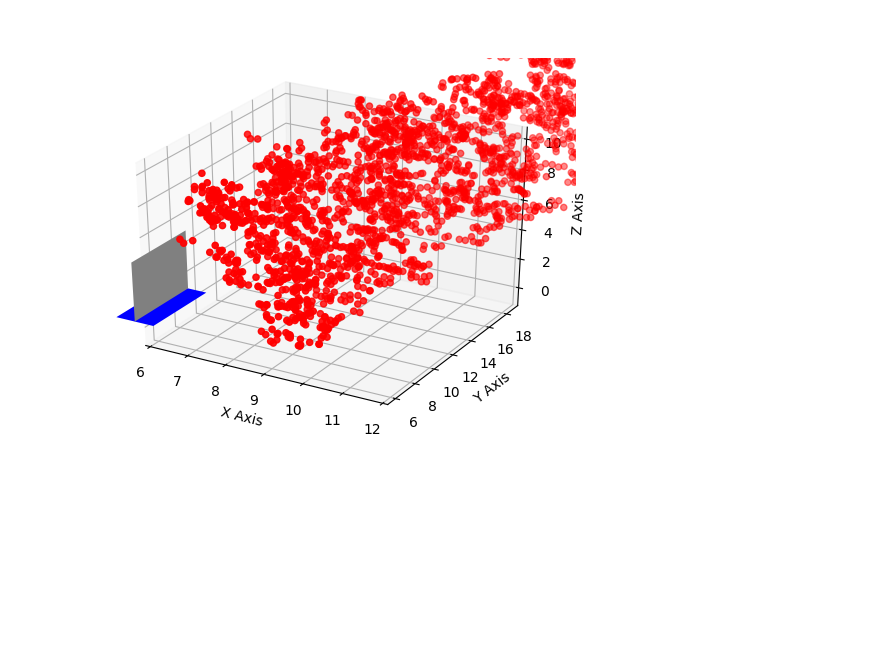

KeyboardInterrupt: 

In [259]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(0,runs):
    if run % 20 == 0:
        ax.clear()
        
        ax.scatter(sortedFruit[0,:], sortedFruit[1,:], sortedFruit[2,:], c='r', marker='o') 
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
#         dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a1.z_edges_f)
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0].z_edges_f)

        
        for count in range(num_arms):
            ax.scatter(a[count].qax[run], a[count].qay[run], a[count].qaz[run])
        
#         ax.scatter(qa0[run], qa1[run], qa2[run], 'b', label='arm1')

        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.5)
       
    
    
fig.show()

